In [29]:
import numpy as np
import geopandas as gpd
import pandas as pd

import scanpy as sc
import voyagerpy as vp
import seaborn as sns
import os
import pickle
from matplotlib.pyplot import imread
from collections import OrderedDict
import json

from matplotlib import pyplot as plt

In [30]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [31]:
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Mouse_Brain_square_example/square_016um"
andata016_ = sc.read_visium(path=path_016)

/gpfs/gsfs10/users/kanferg/conda/envs/voyagerpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/voyagerpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/gsfs10/users/kanferg/conda/envs/voyagerpy/lib/python3.8/site-packages/scanpy/readwrite.py:415: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(files["tissue_positions_file"], header=None)


In [32]:
def print_all_keys(d, parent_key=''):
    if isinstance(d, dict) or isinstance(d, OrderedDict):
        for key, value in d.items():
            new_key = f"{parent_key}.{key}" if parent_key else key
            print(new_key)
            if isinstance(value, dict) or isinstance(value, OrderedDict):
                print_all_keys(value, new_key)

# Example usage with andata016_.uns
print_all_keys(andata016_.uns)

spatial
spatial.Visium_HD_Mouse_Brain
spatial.Visium_HD_Mouse_Brain.images
spatial.Visium_HD_Mouse_Brain.images.hires
spatial.Visium_HD_Mouse_Brain.images.lowres
spatial.Visium_HD_Mouse_Brain.scalefactors
spatial.Visium_HD_Mouse_Brain.scalefactors.spot_diameter_fullres
spatial.Visium_HD_Mouse_Brain.scalefactors.bin_size_um
spatial.Visium_HD_Mouse_Brain.scalefactors.microns_per_pixel
spatial.Visium_HD_Mouse_Brain.scalefactors.regist_target_img_scalef
spatial.Visium_HD_Mouse_Brain.scalefactors.tissue_lowres_scalef
spatial.Visium_HD_Mouse_Brain.scalefactors.fiducial_diameter_fullres
spatial.Visium_HD_Mouse_Brain.scalefactors.tissue_hires_scalef
spatial.Visium_HD_Mouse_Brain.metadata
spatial.Visium_HD_Mouse_Brain.metadata.chemistry_description
spatial.Visium_HD_Mouse_Brain.metadata.software_version


In [33]:
andata016_.obsm['spatial'] = np.array(andata016_.obsm['spatial'], dtype=np.float64)

In [34]:
andata016_.uns['spatial']['img'] = andata016_.uns['spatial']['Visium_HD_Mouse_Brain'].pop("images")
andata016_.uns['spatial']['scale'] = andata016_.uns['spatial']['Visium_HD_Mouse_Brain'].pop("scalefactors")
andata016_.uns['spatial']['metadata'] = andata016_.uns['spatial']['Visium_HD_Mouse_Brain'].pop("metadata")
andata016_.uns['spatial'].pop("Visium_HD_Mouse_Brain")

print_all_keys(andata016_.uns)

spatial
spatial.img
spatial.img.hires
spatial.img.lowres
spatial.scale
spatial.scale.spot_diameter_fullres
spatial.scale.bin_size_um
spatial.scale.microns_per_pixel
spatial.scale.regist_target_img_scalef
spatial.scale.tissue_lowres_scalef
spatial.scale.fiducial_diameter_fullres
spatial.scale.tissue_hires_scalef
spatial.metadata
spatial.metadata.chemistry_description
spatial.metadata.software_version


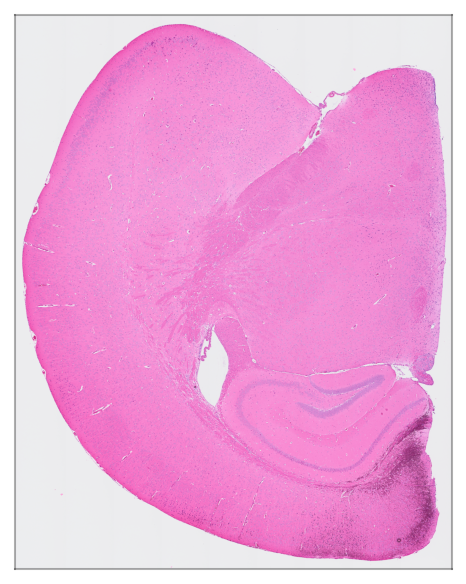

In [35]:
_ = vp.plt.imshow(andata016_)

<center><h3>Quality Control (QC)</h3>


In [36]:
is_mt = andata016_.var_names.str.startswith('mt')
vp.utils.add_per_cell_qcmetrics(andata016_, subsets={'mito': is_mt})

In [37]:
spot_diameter_fullres = andata016_.uns['spatial']['scale'].pop('spot_diameter_fullres')

In [38]:
andata016_.uns['spatial']['scale']['spot_diameter_fullres'] = {'pxl_col_in_fullres':spot_diameter_fullres,'pxl_row_in_fullres':spot_diameter_fullres}


In [39]:
andata016_.uns['spatial']['scale']

{'bin_size_um': 16.0,
 'microns_per_pixel': 0.2738242950835738,
 'regist_target_img_scalef': 0.2505533,
 'tissue_lowres_scalef': 0.02505533,
 'fiducial_diameter_fullres': 1205.1523766336395,
 'tissue_hires_scalef': 0.2505533,
 'spot_diameter_fullres': {'pxl_col_in_fullres': 58.431630382237074,
  'pxl_row_in_fullres': 58.431630382237074}}

In [19]:
andata016_.uns['spatial']['scale']['tissue_lowres_scalef']

0.02505533

In [40]:
# insted of vp.spatial.get_visium_spots(andata016_, with_radius=False) I have done:
#scale = andata016_.uns['spatial']['scale']['tissue_lowres_scalef']
scale = 1
scale_dict = andata016_.uns["spatial"].get("scale", {})
spot_diam = scale_dict.get("spot_diameter_fullres")
visium_spots = gpd.GeoSeries.from_xy(andata016_.obsm['spatial'][:,0], andata016_.obsm['spatial'][:,1]).scale(scale, scale, origin=(0, 0))


In [41]:
_ = vp.spatial.set_geometry(andata016_, geom="spot_poly", values=visium_spots)

In [42]:
andata016_.uns['config'] = OrderedDict()
andata016_.uns["config"]["secondary_var_names"] = andata016_.var_names

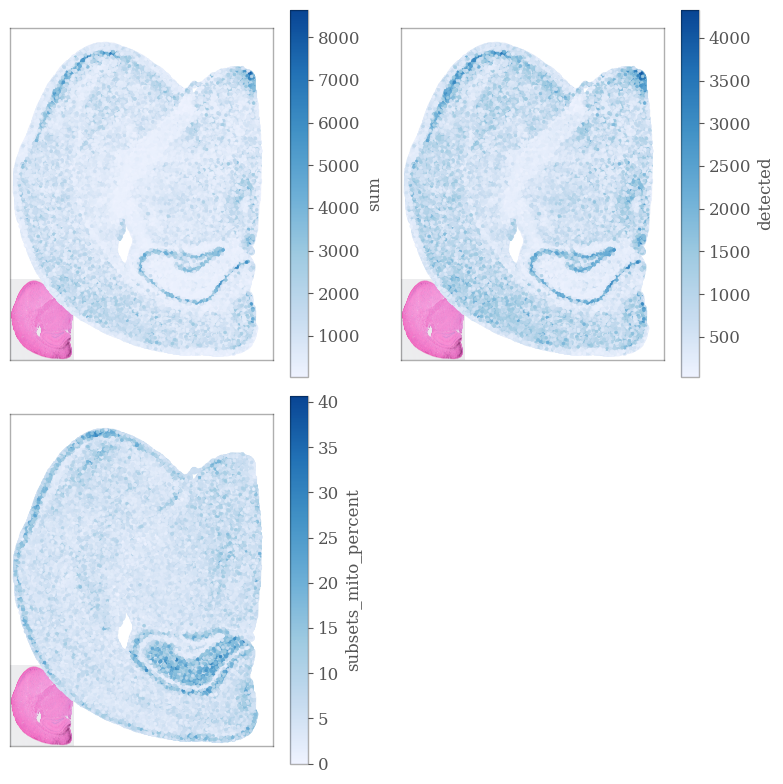

In [43]:
qc_features = ["sum", "detected", "subsets_mito_percent"]
axs = vp.plt.plot_spatial_feature(
    andata016_,
    qc_features,
    image_kwargs=dict(),
    subplot_kwargs=dict(figsize=(8,8), dpi=100, layout='tight')
)

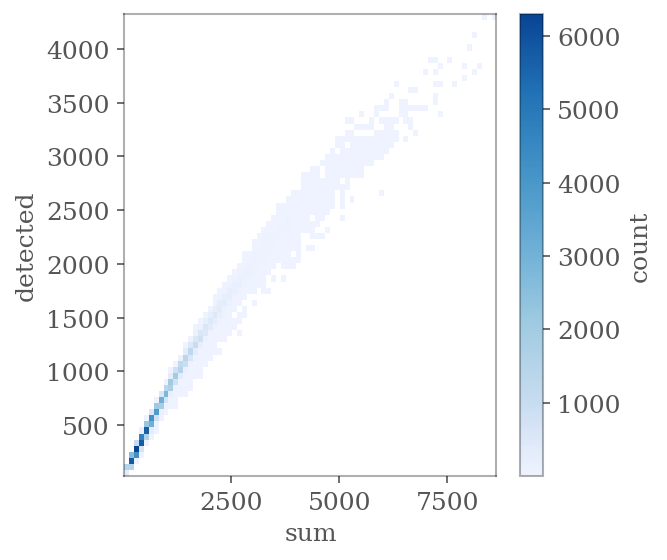

In [44]:
ax = vp.plotting.plot_barcodes_bin2d(
    andata016_,
    x='sum',
    y='detected',
    bins=76,
    figsize=(4, 4)
)

In [45]:
# The original count data
andata016_.layers['counts'] = andata016_.X.copy()
# Log-normalize the adata.X matrix
vp.utils.log_norm_counts(andata016_, inplace=True)
andata016_.layers['logcounts'] = andata016_.X.copy()

In [47]:
andata016_.layers['logcounts'].shape

(98917, 19059)

In [48]:
andata016_.obs['var'] = np.var(andata016_.X.todense(), axis=1)

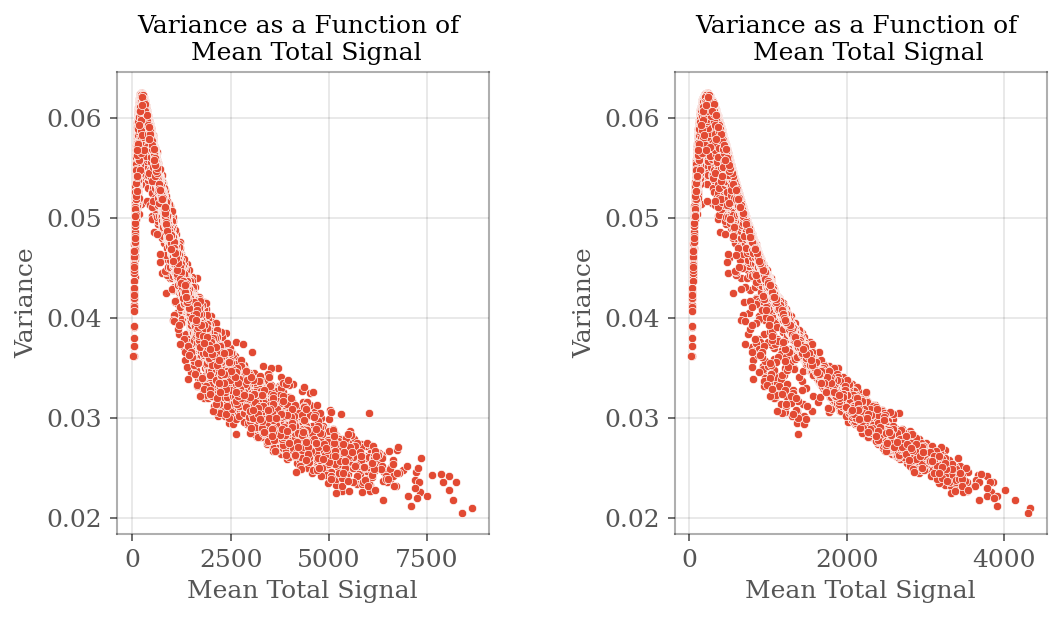

In [49]:
gene_means = andata016_.obs['sum']
var = andata016_.obs['var']

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.scatterplot(x=andata016_.obs['sum'], y=andata016_.obs['var'],ax = axs[0])
sns.scatterplot(x=andata016_.obs['detected'], y=andata016_.obs['var'],ax = axs[1])

# Set plot labels and title
axs[0].set_xlabel('Mean Total Signal')
axs[0].set_ylabel('Variance')
axs[0].set_title('Variance as a Function of \n Mean Total Signal')

axs[1].set_xlabel('Mean Total Signal')
axs[1].set_ylabel('Variance')
axs[1].set_title('Variance as a Function of \n  Mean Total Signal')
plt.subplots_adjust(wspace=0.5)

In [54]:
adata = andata016_.copy()

/gpfs/gsfs10/users/kanferg/conda/envs/voyagerpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [67]:
x = adata.layers['logcounts'].todense()
mean = x.mean(axis = 0).reshape(-1)
var = x.var(axis=0, ddof=1)
var.squeeze

<bound method matrix.squeeze of matrix([[4.3352559e-02, 3.0697440e-04, 1.3513077e-02, ..., 3.5774851e-01,
         1.1338490e+00, 3.9902579e-02]], dtype=float32)>

In [50]:
X = adata.layers['logcounts'].X
names = adata.var_names
del adata
x_means, x_vars = get_mean_var(X, axis=0, ddof=1)

    if subset_fit is None:
        fit_stats_means = x_means
        fit_stats_vars = x_vars
    else:
        return None

    collected = decompose_log_exprs(x_means, x_vars, fit_stats_means, fit_stats_vars, names=names)

(98917, 19059)

In [51]:
andata016_.var_names.shape

(19059,)

In [60]:
vp.utils.model_gene_var(adata.layers['logcounts'].todense(), gene_names=andata016_.var_names)

IndexError: index 4 is out of bounds for axis 0 with size 1

In [27]:
gene_var = vp.utils.model_gene_var(andata016_.layers['logcounts'], gene_names=andata016_.var_names)
hvgs = vp.utils.get_top_hvgs(gene_var)

# Set the 'highly_variable' column for the genes
adata_tissue.var['highly_variable'] = False
adata_tissue.var.loc[hvgs, 'highly_variable'] = True

ValueError: shape mismatch: value array of shape (18992,) could not be broadcast to indexing result of shape (19004,)